# Exercice: décomposition de l'évolution de l'empreinte

Il peut être intéressant d'identifier les causes de variation de l'empreinte carbone d'un pays.

In [1]:
import pymrio as mr   # manipulation des données input-output
import pandas as pd   # manipulation de tables et jeux de données
import numpy as np    # opérations communes
import seaborn as sns # production de figures, add-on à matplotlib
import matplotlib.pyplot as plt # production de figures
import os # opérations sur le système de fichiers

In [2]:
import pickle

In [3]:
EXIOBASE_PATH = '../EXIOBASE/' # ne pas hésiter à changer

In [4]:
years = [1999, 2009, 2019]

In [5]:
# io = dict()

# for year in years:
    
#     filename = EXIOBASE_PATH+'IOT_{}_ixi.zip'.format(year)
#     io[year] = mr.parse_exiobase3(path=filename)
    

In [6]:
# for year in years:
    
#     population = pd.read_csv(EXIOBASE_PATH+'exiobase_population.txt',sep='\t',index_col=0)
#     io[year].population=pd.DataFrame(columns=['population'], data=population.loc[year].values, index=population.columns).T
    
#     io[year].calc_all()

In [8]:
# for year in years:
#     with open(EXIOBASE_PATH + f'IOT_{year}_ixi.pickle', 'wb') as handle:
#         pickle.dump(io[year], handle, protocol=pickle.HIGHEST_PROTOCOL)

# Chargement rapide des données IO
io = dict()
for year in years:
    with open(EXIOBASE_PATH + f'IOT_{year}_ixi.pickle', 'rb') as handle:
        io[year] = pickle.load(handle)

In [9]:
# Calculate one-by-one changes
deltas = dict()

for y,year in enumerate(years[:-1]):
    
    # define original year and new year
    orig = year
    new  = years[y+1]

    print(orig, new)
    
    Y_orig = io[orig].Y
    Y_new  = io[new].Y
    
    L_orig = io[orig].L
    L_new  = io[new].L
    
    S_orig = io[orig].satellite.S
    S_new  = io[new].satellite.S
    
    F_orig = io[orig].satellite.F
    F_new  = io[new].satellite.F
    
    FY_orig = io[orig].satellite.F_Y
    FY_new  = io[new].satellite.F_Y
    
    # original year on the left, then the difference, then the new year
    dS = 1/2 *((S_new - S_orig).dot(L_new.dot(Y_new) + L_orig.dot(Y_orig)))
    dL = 1/2 * (S_orig.dot((L_new - L_orig).dot(Y_new)) + S_new.dot((L_new - L_orig).dot(Y_orig)))
    dY = 1/2 * (S_orig.dot( L_orig.dot(Y_new - Y_orig)) + S_new.dot(L_new.dot(Y_new - Y_orig)))
    dF = F_new - F_orig
    dE = S_new.dot(L_new.dot(Y_new)) - S_orig.dot(L_orig.dot(Y_orig))
    dFY = FY_new - FY_orig
    
    deltas[new] = {'ΔS':dS,
                   'ΔL':dL,
                   'ΔY':dY,
                   'ΔE':dE}
#                    'dF':dF}
#                    'dFY':dFY}

1999 2009
2009 2019


In [23]:
ind_CO2 = 'CO2 - combustion - air'

In [40]:
ind_GHG = results.loc[('2009–2019','ΔE')].index[23:26]
ind_GHG

Index(['CO2 - combustion - air', 'CH4 - combustion - air',
       'N2O - combustion - air'],
      dtype='object', name='stressor')

In [25]:
results = pd.concat([pd.concat(deltas[year]) for year in years[1:]], keys=['1999–2009', 
                                                                           '2009–2019'])

In [27]:
 np.allclose(results.loc[('2009–2019','ΔS')] + results.loc[('2009–2019','ΔL')] + results.loc[('2009–2019','ΔY')],
            results.loc[('2009–2019','ΔE')])

True

In [57]:
fig_data = dict()

for substance in ind_GHG:
    
    #fig_data[substance] = pd.concat([results.loc[(slice(None), slice(None), substance)].sum(1)]).unstack()
    fig_data[substance] = pd.concat([results.loc[:,'LU'].loc[(slice(None), slice(None), substance)].sum(1)]).unstack()

In [58]:
fig_data[ind_CO2]

,ΔS,ΔL,ΔY,ΔE
1999–2009,-2.736488e+09,1.279420e+09,3.770047e+09,2.312978e+09
2009–2019,1.194501e+11,-1.235365e+11,7.274743e+09,3.188308e+09


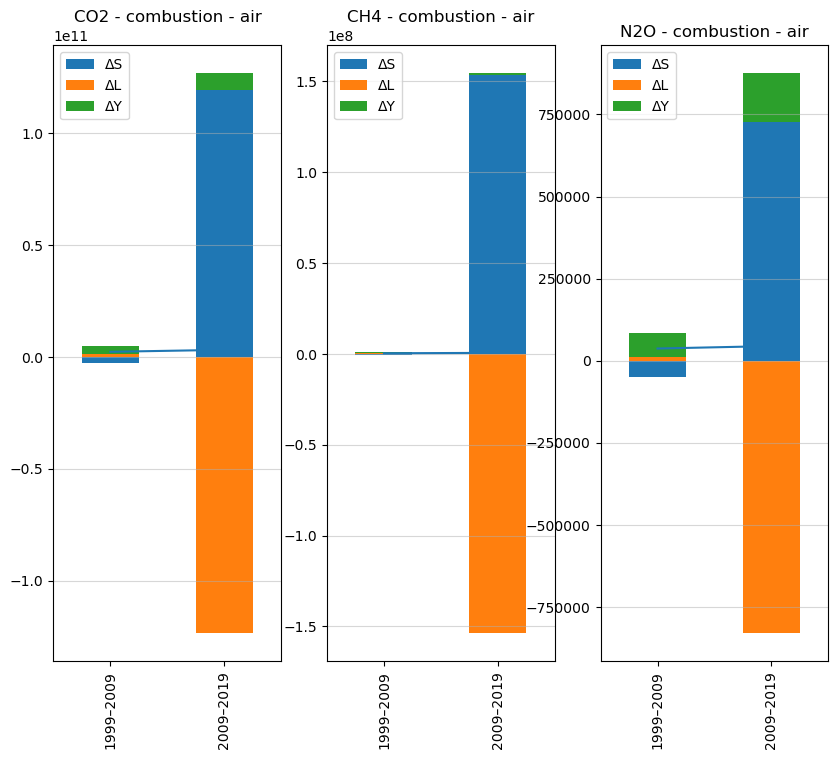

In [60]:
fig, axes = plt.subplots(1,3,figsize=(10,8))

for i,substance in enumerate(ind_GHG):
    ax=axes[i]
    fig_data[substance].iloc[:,:-1].plot(kind='bar',stacked=True, ax=ax)
    ax.plot(fig_data[substance]['ΔE'])
    ax.grid(True, axis='y', which='both', alpha=0.5)
    ax.set_title(substance)